In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm # стандартные регрессионные модели
import statsmodels.formula.api as smf # аналогичные модели с синтаксисом в стиле R
import statsmodels.graphics.gofplots as gf # визуализация моделей
import statsmodels.discrete.discrete_model # дискретные модели
from statsmodels.stats.outliers_influence import summary_table # работа с выбросами
from scipy.stats import norm

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('Homework_2_data.csv', sep=';')

In [5]:
df = df[(df['region']=='Челябинск')& (df['year']==2023)]

In [7]:
def replace_comma(x):
    if isinstance(x, str):
        return x.replace(',', '.')
    return x

df['age'] = df['age'].apply(replace_comma).astype(float)
df['wage'] = df['wage'].apply(replace_comma).astype(float)
df['weight'] = df['weight'].apply(replace_comma).astype(float)
df['height'] = df['height'].apply(replace_comma).astype(float)

# 1

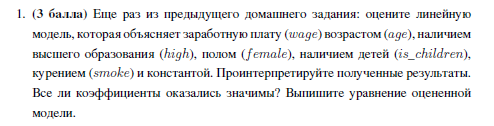

In [11]:
df['is_children'].value_counts()

is_children
1    132
Name: count, dtype: int64

Так как is_children = 1 для всех наблюдений, она дублирует константу и некорректно добавлять ее в модель. Поэтому я удалил ее из модели

In [14]:
ols_10 = smf.ols('wage ~ age + educ + female + smoke', data=df).fit()
print(ols_10.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     7.220
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           2.85e-05
Time:                        17:26:56   Log-Likelihood:                -1580.2
No. Observations:                 132   AIC:                             3170.
Df Residuals:                     127   BIC:                             3185.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.567e+04   1.99e+04      3.793      0.0

## Уравнение оцененной модели:

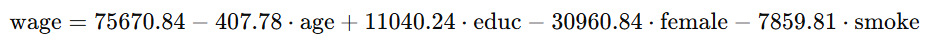

## Значимость коэффициентов

На уровне значимости 5% **статистически значимы коэффициенты перед переменными female (пол) и educ (уровень образования)**. Остальные переменные незначимы.\
Это связано с **маленьким количеством наблюдений** (всего 132 наблюдения). Плюс **данные по зарплате очень шумные, много выбросов**. Поэтому далее я построю еще несколько моделей, в том числе модель с логарифмированной зарплатой.\
**Формы зависимости нелинейные**, например зависимость от возраста затухающая (как я уже убедился в дз2)

# 2

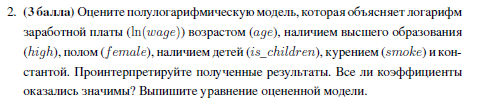

In [22]:
df['log_wage'] = np.log1p(df['wage'])

In [24]:
ols_10_logwage = smf.ols('log_wage ~ age + educ + female + smoke', data=df).fit()
print(ols_10_logwage.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     11.16
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           8.65e-08
Time:                        17:27:18   Log-Likelihood:                -106.29
No. Observations:                 132   AIC:                             222.6
Df Residuals:                     127   BIC:                             237.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9882      0.282     38.937      0.0

Ситуация улучшилась. Теперь **на уровне значимости 5% значимы те же регрессоры**. При этом доля объясненной дисперсии (R^2) значительно выросла (с 0.185 до 0.26), что подтверждает уместность логарифмирования зарплат

**R^2 значительно вырос**, модель лучше объясняет дисперсию зависимой переменнной.\
**Распределение остатков стало ближе к нормальному** (Skew = -0.4, Kurtosis = 7), что более чем адекватно по сравнению с базовой моделью.

### Интерпретация коэффициентов

**age**: При увеличении возраста на 1 год зарплата падает на ~0.6%, если остальные переменные постоянны\
**educ**: Каждый дополнительный уровень образования увеличивает заработную плату в среднем на 18.3% (коэффициент небольшой, поэтому интерпретируем напрямую)\
**female**: Женщины зарабатывают в среднем на 44% меньше мужчин (коэффициент по модулю больше 0.2 => для интерпретации я применил преобразование (e^b - 1)*100)\
**smoke**: Курящие зарабатывают в среднем на 5.1% меньше, но этот эффект незначим

# 3

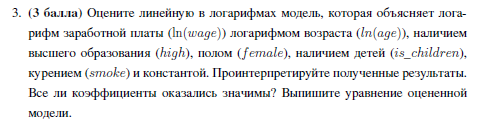

In [32]:
df['log_age'] = np.log1p(df['age'])

In [34]:
ols_10_logwage_logage = smf.ols('log_wage ~ log_age + educ + female + smoke', data=df).fit()
print(ols_10_logwage_logage.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     11.00
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           1.08e-07
Time:                        17:27:34   Log-Likelihood:                -106.53
No. Observations:                 132   AIC:                             223.1
Df Residuals:                     127   BIC:                             237.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.4879      0.913     12.584      0.0

**R^2 незначительно упал**\
**Значимы все те же переменные**

## Уравнение оцененной модели:

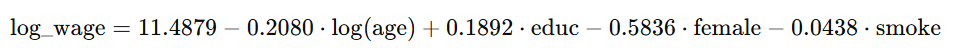

## Интерпретация коэффициентов

**logage**: При увеличении возраста на 1% год, ожидаемая зарплата падает на ~0.2%, если остальные переменные постоянны\
**educ**: Каждый дополнительный уровень образования увеличивает заработную плату в среднем на 18.9% (коэффициент небольшой, поэтому интерпретируем напрямую)\
**female**: Женщины зарабатывают в среднем на 44% меньше мужчин (коэффициент по модулю больше 0.2 => для интерпретации я применил преобразование (e^b - 1)*100)\
**smoke**: Курящие зарабатывают в среднем на 4.3% меньше, но этот эффект незначим

# 4

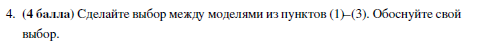

**По R^2 и AIC лучшая модель - полулогарифмическая модель**, и по логике она является наилучшей здесь 

Проведу тесты, чтобы убедиться в этом:

## J-тест Дэвидсона-Маккинона

Я сразу исключу линейную модель, так как у нее существенно меньший R^2 по сравнению с другими моделями.\
Сравним полулогарифмическую и лог-лог модель:

In [47]:
# Предсказания от лог-лог модели
df['pred_loglog'] = ols_10_logwage_logage.fittedvalues

# Предсказания от полулог модели
df['pred_semi'] = ols_10_logwage.fittedvalues

In [49]:
jtest_1 = smf.ols('log_wage ~ age + educ + female + smoke + pred_loglog', data=df).fit()
print("J-тест: лог-лог лучше полулог?")
print(jtest_1.summary())

J-тест: лог-лог лучше полулог?
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     9.663
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           7.90e-08
Time:                        17:27:51   Log-Likelihood:                -104.75
No. Observations:                 132   AIC:                             221.5
Df Residuals:                     126   BIC:                             238.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     172.7

на 5% уровне значимости коэффициент перед pred_loglog не значим, значит лог-лог **не содержит доп информацию**

In [52]:
jtest_2 = smf.ols('log_wage ~ log_age + educ + female + smoke + pred_semi', data=df).fit()
print("J-тест: полулог лучше лог-лог?")
print(jtest_2.summary())

J-тест: полулог лучше лог-лог?
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     9.663
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           7.90e-08
Time:                        17:27:52   Log-Likelihood:                -104.75
No. Observations:                 132   AIC:                             221.5
Df Residuals:                     126   BIC:                             238.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -134.9505

**Обе модели (полулог и лог-лог) статистически равнозначны по J-тесту.**\
Я выбираю полулог модель, так как она проще в интерпретации, и лучше подходит в тандеме с квадратом возраста (как я ранее заметил в дз2)

# 5

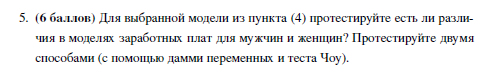

## С помощью дамми-переменных

In [58]:
model_full = smf.ols('log_wage ~ age + educ + smoke + female*(age + educ + smoke)', data=df).fit()
model_restricted = smf.ols('log_wage ~ age + educ + smoke + female', data=df).fit()

f_test = model_full.compare_f_test(model_restricted)
print(f"F-statistic: {f_test[0]}, p-value: {f_test[1]}")

F-statistic: 2.7732639700640753, p-value: 0.044292124855567404


**Модели статистически различаются для мужчин и женщин**

## тест Чоу

In [62]:
model_pooled = smf.ols('log_wage ~ age + educ + smoke', data=df).fit()
RSS_pooled = sum(model_pooled.resid ** 2)
n_total = model_pooled.nobs
k = model_pooled.df_model + 1  # число параметров, включая константу

# Модель для женщин
df_women = df[df['female'] == 1]
model_women = smf.ols('log_wage ~ age + educ + smoke', data=df_women).fit()
RSS_women = sum(model_women.resid ** 2)
n_women = model_women.nobs

# Модель для мужчин
df_men = df[df['female'] == 0]
model_men = smf.ols('log_wage ~ age + educ + smoke', data=df_men).fit()
RSS_men = sum(model_men.resid ** 2)
n_men = model_men.nobs

# Расчет F-статистики
numerator = (RSS_pooled - (RSS_women + RSS_men)) / k
denominator = (RSS_women + RSS_men) / (n_women + n_men - 2 * k)
F_stat = numerator / denominator

from scipy.stats import f
p_value = 1 - f.cdf(F_stat, dfn=k, dfd=n_women + n_men - 2 * k)

print(f"F = {F_stat:.4f}, p-value = {p_value:.4f}")


F = 10.6885, p-value = 0.0000


**p-value < 0.05 => модели различаются для мужчин и женщин**

Таким образом, оба способа привели нас к одному результату, который, исходя из прошлых результатов моделирования, для меня ожидаем.\
**Женщины получают значительно меньше, чем мужчины**

# 6

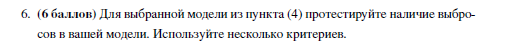

## QQ-plot

<Figure size 1000x800 with 0 Axes>

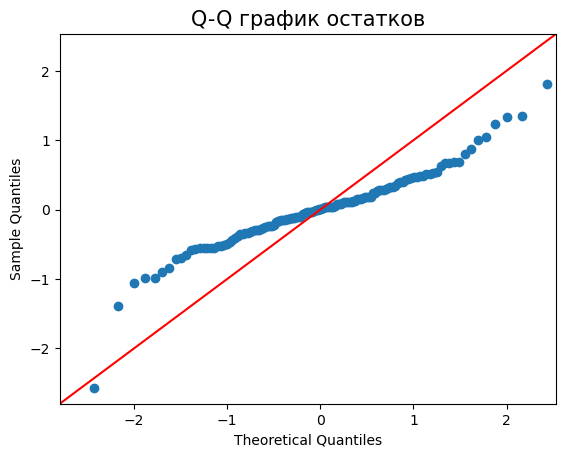

In [69]:
plt.figure(figsize=(10, 8))
sm.qqplot(ols_10_logwage.resid, line='45')
plt.title("Q-Q график остатков", fontsize=15)
plt.show()

**Основная масса остатков распределена нормально**. Наличие нескольких выбросов в хвостах не искажает общую форму

## Анализ DFFITS и DFBETA

In [73]:
influence = ols_10_logwage.get_influence()

from statsmodels.stats.outliers_influence import OLSInfluence

dffits, _ = influence.dffits
df['dffits'] = dffits

#выбросы, если |DFFITS| > 2 * sqrt(k / n)
n = ols_10_logwage.nobs
k = ols_10_logwage.df_model + 1  
threshold = 2 * (k / n) ** 0.5

df_dffits_outliers = df[abs(df['dffits']) > threshold]

In [75]:
df_dffits_outliers.shape

(7, 21)

In [77]:
dfbetas = influence.dfbetas
df_betas = pd.DataFrame(dfbetas, columns=ols_10_logwage.params.index)
df_betas['max_abs'] = df_betas.abs().max(axis=1)

df['dfbeta_max'] = df_betas['max_abs'].values

#выбросы, если |DFBETA| > 2 / sqrt(n)
threshold_dfbeta = 2 / n**0.5

df_dfbeta_outliers = df[df['dfbeta_max'] > threshold_dfbeta]

In [79]:
df_dfbeta_outliers.shape

(19, 22)

**Исходя из dffits и dfbeta выбросов очень много**

# 7

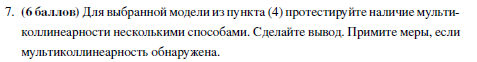

## Матрица корреляций

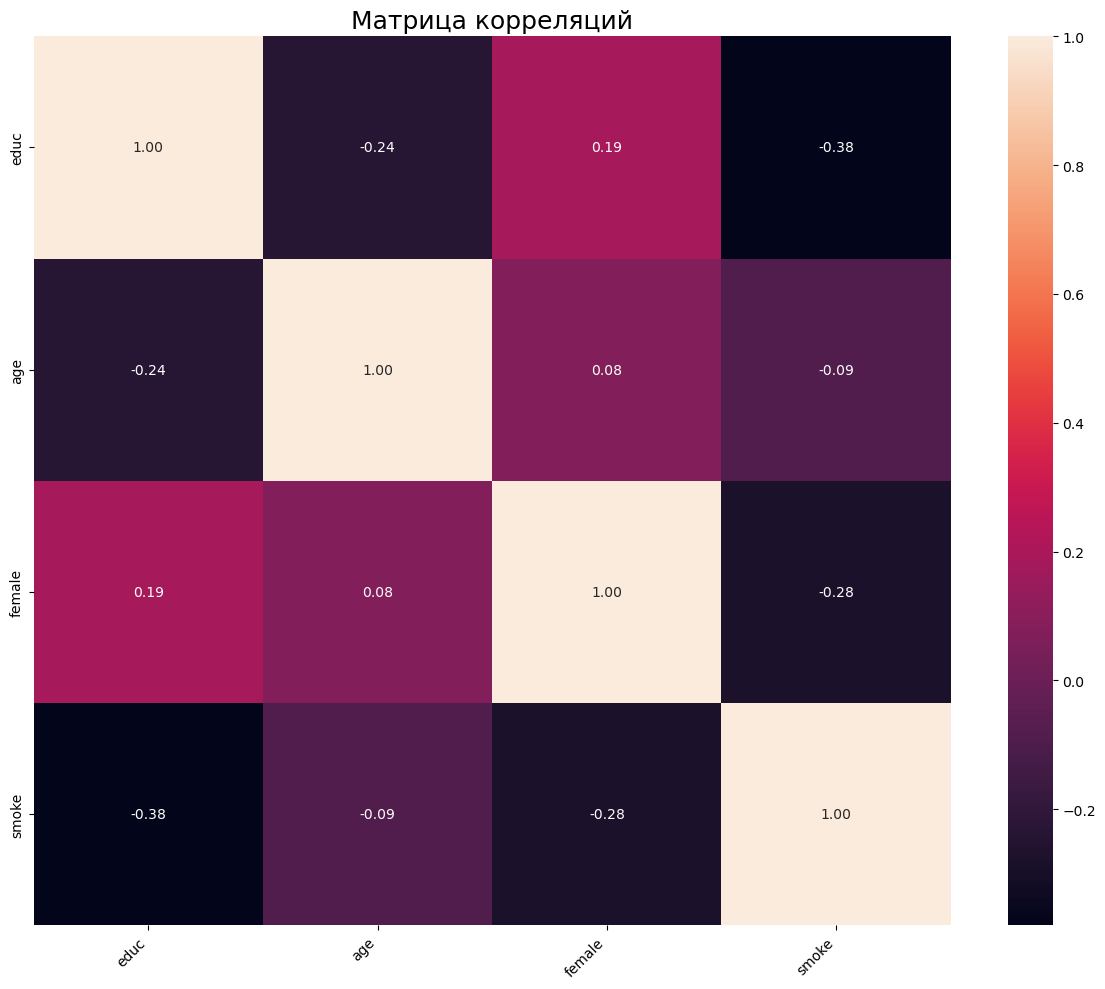

In [85]:
plt.figure(figsize=(12, 10))

sns.heatmap(df[['educ', 'age', 'female', 'smoke']].corr(), annot=True, fmt=".2f")

plt.title("Матрица корреляций", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

**Нет сильных корреляций (>0.8), даже умеренных нет**

## VIF

In [89]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


X = df[['age', 'educ', 'female', 'smoke']]
X = sm.add_constant(X)  


vif_data = pd.DataFrame()
vif_data["variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  variable        VIF
0    const  34.513303
1      age   1.115827
2     educ   1.301323
3   female   1.102027
4    smoke   1.275980


По всем регрессорам кроме константы VIF < 5, поэтому **мультиколлинеарности нет** (на VIF у константы не стоит смотреть)

# 8

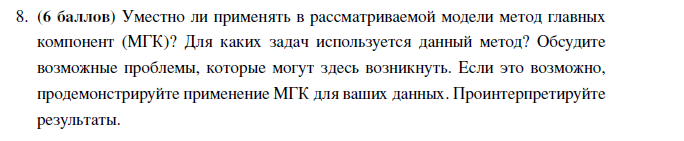

В данной модели **неуместно применять МГК** по следующим причинам: 
1. В модели нет проблем, которые решает МГК (мультиколлинеарность, большое количество переменных).
2. Теряется интерпретируемость коэффициентов перед факторами

Данный метод используется для:
1. **Сокращения размерности** (упрощения модели без существенной потери информации). Часто применяется в кредитном скоринге
2. **Борьбы с мультиколлинеарностью**: заменяем большое количество коррелированных предикторов на небольшое количество некоррелированных компонент. Часто применяется при прогнозировании макроэкономических показателей

# 9

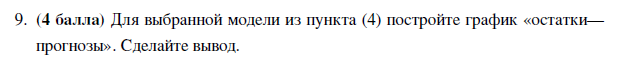

In [108]:
df.head()

,region,educ,age,female,industry,work_hours,wage,foreign_language,internet,alcohol,...,weight,height,smoke,year,log_wage,log_age,pred_loglog,pred_semi,dffits,dfbeta_max
329,Челябинск,0,41.0,1,ДРУГАЯ ОТРАСЛЬ ТЯЖЕЛОЙ ПРОМЫШЛЕННОСТИ,12,100000.0,0,1,1,...,81.0,162.0,0,2023,11.512935,3.737670,10.153665,10.174282,0.564005,0.431307
330,Челябинск,0,37.5,1,ДРУГАЯ ОТРАСЛЬ ТЯЖЕЛОЙ ПРОМЫШЛЕННОСТИ,8,20000.0,0,1,1,...,58.0,162.0,1,2023,9.903538,3.650658,10.127363,10.142884,-0.100203,0.059376
331,Челябинск,1,52.0,0,"ТРАНСПОРТ, СВЯЗЬ",8,50000.0,0,1,1,...,83.0,175.0,0,2023,10.819798,3.970292,10.879763,10.876740,-0.017863,0.012552
332,Челябинск,2,50.0,1,ОПЕРАЦИИ С НЕДВИЖИМОСТЬЮ,8,40000.0,0,1,1,...,79.0,163.0,0,2023,10.596660,3.931826,10.493081,10.489949,0.029868,0.015407
333,Челябинск,0,52.5,1,"ТОРГОВЛЯ, БЫТОВОЕ ОБСЛУЖИВАНИЕ",8,34000.0,0,1,1,...,79.0,174.0,0,2023,10.434145,3.979682,10.105065,10.109093,0.115843,0.081288


In [110]:
df.columns

Index(['region', 'educ', 'age', 'female', 'industry', 'work_hours', 'wage',
       'foreign_language', 'internet', 'alcohol', 'is_children', 'health',
       'weight', 'height', 'smoke', 'year', 'log_wage', 'log_age',
       'pred_loglog', 'pred_semi', 'dffits', 'dfbeta_max'],
      dtype='object')

Text(0, 0.5, 'Остатки')

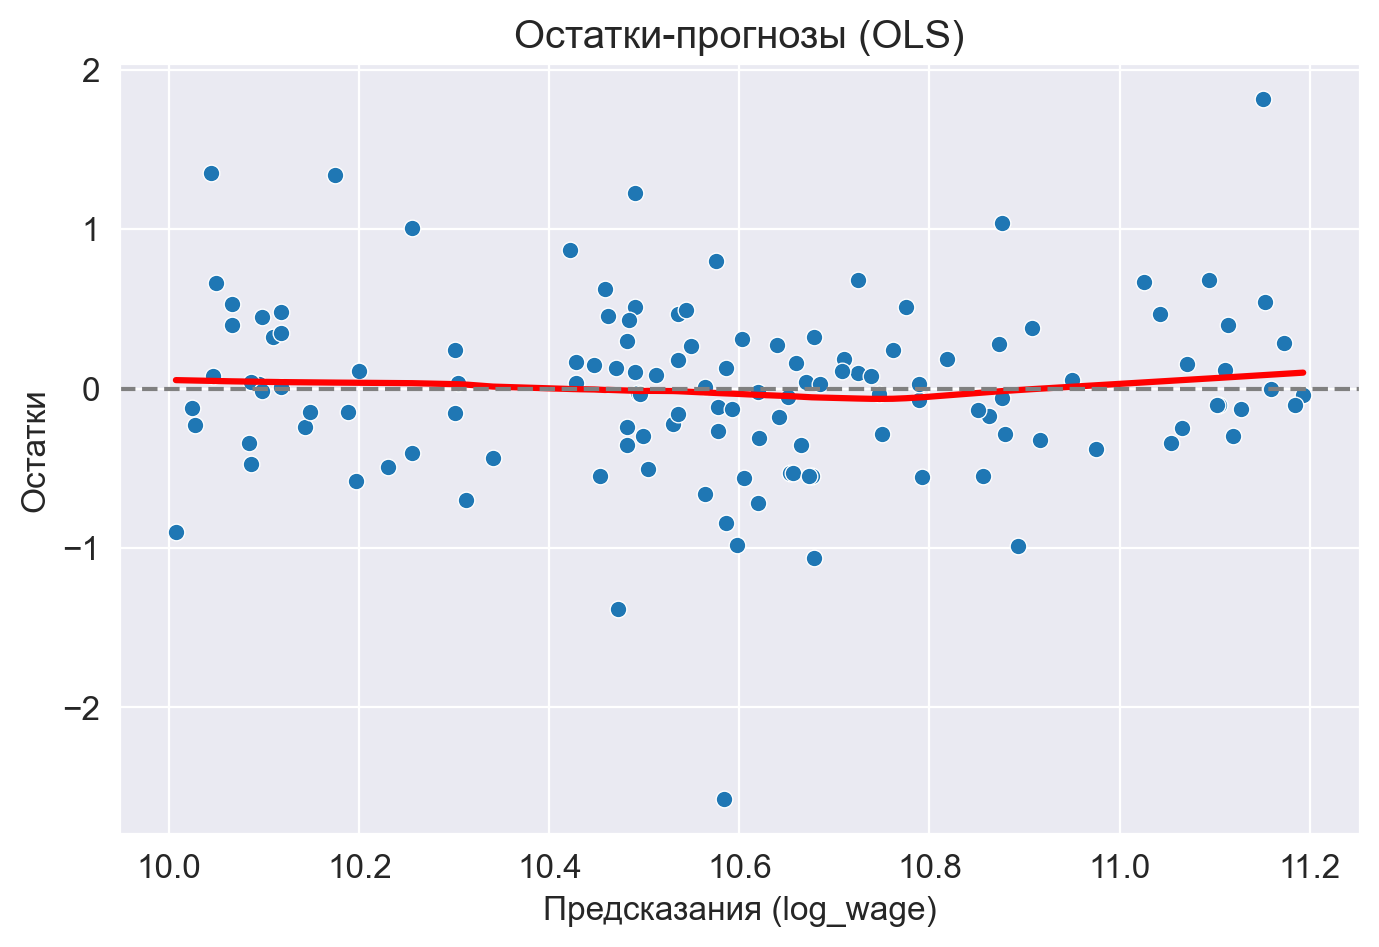

In [128]:
df['resid_semi'] = ols_10_logwage.resid

sns.scatterplot(x='pred_semi', y='resid_semi', data=df)
sns.regplot(x='pred_semi', y='resid_semi', data=df, scatter=False,
            lowess=True, color='red')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Остатки-прогнозы (OLS)')
plt.xlabel('Предсказания (log_wage)')
plt.ylabel('Остатки')

**Модель адекватна**, так как нет выраженных паттернов (воронка/дуга).
Есть единичные выбросы, но это не критично

# 10

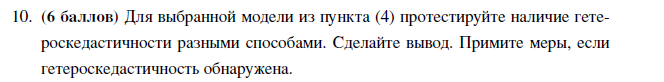

## Тесты Уайта, Глейзера, Бройша-Пагана

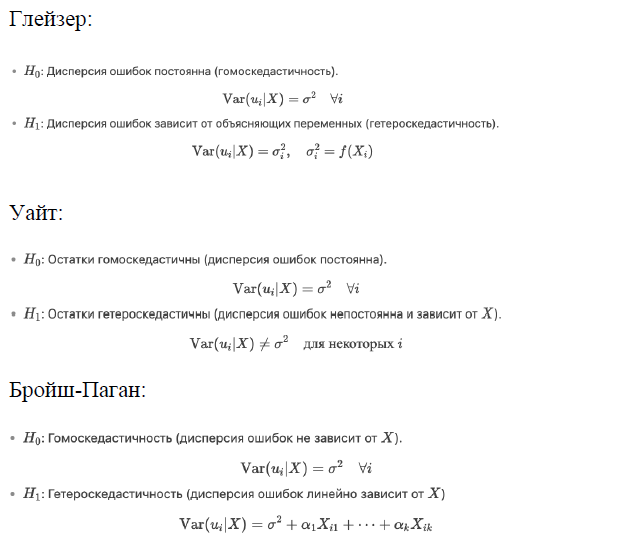

**У всех трёх тестов нулевая гипотеза заключается в отсутствии гетероскедастичности**

### тест Уайта

**Проведем тесты на уровне значимости 5%**

In [147]:
white_test = sms.het_white(ols_10_logwage.resid, ols_10_logwage.model.exog)
print(f'p-value в тесте Уайта = {round(white_test[1], 2)}')

p-value в тесте Уайта = 0.88


p-value > 0.05 => Согласно тесту Уайта, **гетероскедастичности нет** (нулевая гипотнза не отвергается)

### тест Бройша-Пагана

In [153]:
bp_test = sms.het_breuschpagan(ols_10_logwage.resid, ols_10_logwage.model.exog)
print(f'p-value в тесте Бройша-Пагана = {round(bp_test[1], 2)}')

p-value в тесте Бройша-Пагана = 0.51


p-value > 0.05 => Согласно тесту Бройша-Пагана, **гетероскедастичности нет** (нулевая гипотнза не отвергается)

### тест Глейзера

In [160]:
abs_residuals = np.abs(ols_10_logwage.resid)
glejser_model = sm.OLS(abs_residuals, ols_10_logwage.model.exog).fit()
print(glejser_model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2653      0.197      1.348      0.180      -0.124       0.655
x1          9.976e-05      0.004      0.028      0.978      -0.007       0.007
x2             0.0441      0.042      1.050      0.296      -0.039       0.127
x3             0.0864      0.071      1.225      0.223      -0.053       0.226
x4             0.0586      0.078      0.751      0.454      -0.096       0.213


Для всех коэффициентов вспомогательной регрессии p-value > 0.05 => **гетероскедастичности нет** согласно тесту Глейзера

**Все 3 теста показали отсутствие гетероскедастичности, поэтому будем считать, что ее в нашей модели нет**

# 11

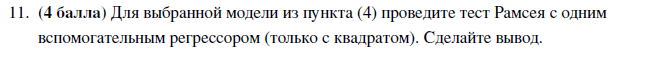

In [180]:
from statsmodels.stats.outliers_influence import reset_ramsey

reset_result = reset_ramsey(ols_10_logwage, degree=2)

In [182]:
print(f"p-value: {reset_result.pvalue:.4f}")

p-value: 0.0192


Так как p-value в тесте Рамсея < 0.05, **модель неправильно специфицирована** (пропущены важные переменые/нелинейные эффекты)

Скорее всего это связано с тем, что я не включал в модель квадрат возраста **(подробное исследование зависимости зарплаты от возраста я провел во втором ДЗ, оно лежит в этом же репозитории)**

# 12

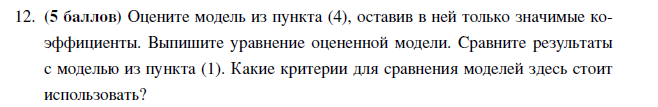

In [188]:
#ols_10_logwage = smf.ols('log_wage ~ age + educ + female + smoke', data=df).fit()
print(ols_10_logwage.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     11.16
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           8.65e-08
Time:                        15:37:40   Log-Likelihood:                -106.29
No. Observations:                 132   AIC:                             222.6
Df Residuals:                     127   BIC:                             237.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.9882      0.282     38.937      0.0

Оставляем только значимые коэффициенты: educ, female

In [196]:
ols_15_logwage = smf.ols('log_wage ~ educ + female', data=df).fit()
print(ols_15_logwage.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     21.79
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           7.02e-09
Time:                        15:48:20   Log-Likelihood:                -106.96
No. Observations:                 132   AIC:                             219.9
Df Residuals:                     129   BIC:                             228.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.6820      0.084    127.832      0.0

## Сравнение моделей

In [201]:
print(round(ols_10_logwage.rsquared_adj, 3))
print(round(ols_15_logwage.rsquared_adj, 3))

0.237
0.241


In [205]:
print(ols_10_logwage.aic, ols_10_logwage.bic)
print(ols_15_logwage.aic, ols_15_logwage.bic)

222.57997574383043 236.9939853567623
219.91786398991522 228.56626975767432


In [208]:
# F-test на вложенность моделей
f_test_result = ols_10_logwage.compare_f_test(ols_15_logwage)
print(f"F = {f_test_result[0]}, p-value = {f_test_result[1]}")

F = 0.6468780143280028, p-value = 0.52539478344898


R^2 adjusted увеличился после удаления незначимого признака => **доля объясненной дисперсии увеличилась**.\
Критерии AIC и BIC уменьшились => **усеченная модель сохраняет качество при меньшем числе параметров**\
p-value в F-test на вложенность моделей равно 0.43 => **удаление фактора smoke не ухудшило модель**\
Таким образом, **усеченная модель предпочтительнее полной**

Выводы получились аналогичные HW2, поэтому не менял их

# 13

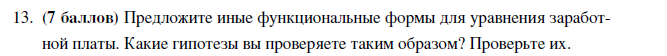

## Модель с квадратом возраста

Попробуем добавить квадрат возраста в модель, как в HW2

In [221]:
ols_13_logwage = smf.ols('log_wage ~ age + I(age**2) + educ + female', data=df).fit()
print(ols_13_logwage.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     12.03
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           2.55e-08
Time:                        16:12:59   Log-Likelihood:                -104.97
No. Observations:                 132   AIC:                             219.9
Df Residuals:                     127   BIC:                             234.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.5849      0.847     11.322      

Проверим гипотезу, что **тест Рамсея для исходной модели демонстрировал проблемы из-за пропущенного квадрата возраста**.\
Если тест Рамсея для модели с квадратом возраста покажет, что модель адекватна, можно будет не отвергать эту гипотезу

In [226]:
reset_result13 = reset_ramsey(ols_13_logwage, degree=3) #degree=3 является стандартным вариантом

In [228]:
print(f"p-value: {reset_result13.pvalue:.4f}")

p-value: 0.0357


p-value < 0.05. Значит, в модели **пропущены еще какие-то нелинейности**.\
**Попробуем посмотреть на взаимодействие уровня образования и пола:**

## Добавляем взаимодействие образования и пола

In [231]:
ols_13_logwage_int = smf.ols('log_wage ~ age + I(age**2) + educ + female + educ:female', data=df).fit()
print(ols_13_logwage_int.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     11.47
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           3.87e-09
Time:                        16:28:42   Log-Likelihood:                -101.41
No. Observations:                 132   AIC:                             214.8
Df Residuals:                     126   BIC:                             232.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.1751      0.842     10.901      

In [236]:
reset_result13_int = reset_ramsey(ols_13_logwage_int, degree=3) #degree=3 является стандартным вариантом
print(f"p-value: {reset_result13_int.pvalue:.4f}")

p-value: 0.5170


p-value в тесте Рамсея > 0.05, значит добавление взаимодействия educ:female устранило ту проблему, которую тест Рамсея находил в предыдущей модели.\
**Теперь нет признаков пропущенных нелинейностей или неправильной функциональной формы**\
**Все коэффициенты в модели статистически значимы на уровне значимости 10%.** Это значит, что добавленное взаимодействие убрало смещение.\
R**2 adj значительно вырос, что говорит о том, что **новая модель лучше объясняет дисперсию зависимой переменной**

### Зависимость эффекта образования от пола

**educ:female = -0.2827**\
**Отдача от дополнительного уровня образования для женщин значительно ниже, чем для мужчин.** Это классический признак гендерного неравенства на рынке труда, дискриминации.

При увеличении образования на 1 единицу (например, на один уровень), логарифм зарплаты мужчины увеличивается на 0.3352. Это означает, что **его зарплата увеличивается примерно на (exp(0.3352) - 1) * 100% ≈ 39.8%**\
При увеличении образования на 1 единицу, логарифм зарплаты женщины увеличивается только на 0.0525. Это означает, что **ее зарплата увеличивается примерно на (exp(0.0525) - 1) * 100% ≈ 5.4%**

### Проверка модели

Проверим, нет ли в модели **гетероскедастичности**:

In [247]:
bp_test_int = sms.het_breuschpagan(ols_13_logwage_int.resid, ols_13_logwage_int.model.exog)
print(f'p-value в тесте Бройша-Пагана = {round(bp_test_int[1], 2)}')

p-value в тесте Бройша-Пагана = 0.59


Тес не увидел наличие гетероскедастичности, но я все равно решил перейти на модель с **робастными стандартными ошибками**, так как тест имеет ограниченную мощность, особенно с учетом маленького числа наблюдений (у нас их всего 132).\
По опыту других исследований, **в данных о заработной плате гетероскедастичность - это скорее правило**

In [250]:
ols_robust = ols_13_logwage_int.get_robustcov_results(cov_type='HC3')
print(ols_robust.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     10.69
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           1.40e-08
Time:                        17:25:43   Log-Likelihood:                -101.41
No. Observations:                 132   AIC:                             214.8
Df Residuals:                     126   BIC:                             232.1
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.1751      0.791     11.596      

## Добавляем взаимодействие возраста и пола

In [253]:
ols_13_logwage_int_int = smf.ols('log_wage ~ age + I(age**2) + educ + female + educ:female + age:female + I(age**2):female', data=df).fit()

ols_robust_2 = ols_13_logwage_int_int.get_robustcov_results(cov_type='HC3')
print(ols_robust_2.summary())

                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     7.678
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           1.08e-07
Time:                        17:33:27   Log-Likelihood:                -98.842
No. Observations:                 132   AIC:                             213.7
Df Residuals:                     124   BIC:                             236.7
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             10.7209      1

Взаимодействие пола с возрастом (age:female) и его квадратом (I(age**2):female) **не является статистически значимым.**

При этом взаимодействие пола с образованием (educ:female) остается значимым даже в этой перегруженной модели (p-value=0.016).\
Это подтверждает устойчивось вывода: **гендерный разрыв проявляется в разной отдаче от образования, а не в разной отдаче от опыта.**

# 14

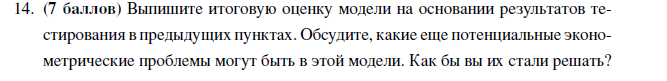

## Итоговая модель

**В итоге я остановился на следующей модели:**

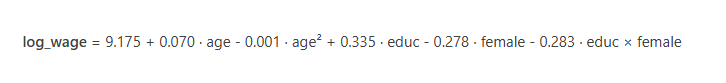

Она **правильно специфицирована, согласно тесту Рамсея**, **коэффициенты при всех регрессорах статистически-значимы**

## Потенциальные эконометрические проблемы

**1. Пропущенные переменные**\
Зарплата зависит от множества других факторов, которые мы не можем учесть, в силу ограниченного набора данных. Например, мы имеем только возраст, а более важным фактором является опыт работы. Также мы не испльзуем данные об отрасли занятости (зарплата в сфере образрвания и IT секторе сильно различаются). И это только самые очевидные пропущенные переменные.\
**Решение**: сбор данных, использование данных об отрасли занятости и других факторов, использование инструментальных переменных.

**2. Эндогенность**\
Например, переменная educ может быть эндогенной, так как более способные и мотивированные люди (чья ненаблюдаемая характеристика входит в ошибку) получают более высокое образование и имеют более высокую зарплату. В этом случае ваша оценка отдачи от образования (0.335) будет завышенной, так как она "вбирает" в себя эффект способностей (классическая эконометрическая проблема)\
**Решение**: использовать качественные инструментальные переменные

**3. Выборка (Смещение отбора)**\
Модель оценена только по тем людям, кто имеет работу. При этом решение работать или нет не является случайным. Например, женщины с маленькими детьми могут с меньшей вероятностью выходить на рынок труда, и если они выходят, то это могут быть более мотивированные и высокооплачиваемые женщины. Это может смещать оценку гендерного разрыва.\
**Решение**: использовать модель Хекмана, которая включает в себя как уравнение отбора, так и основное уравнение. Таким образом решится проблема смещения гендерного разрыва в оплате труда


Возможны и другие проблемы (мультиколлинеарность, нелинейность), но я разобрал основные, которые могут возникнуть в данном случае